# Extract data

In [1]:
import nn_utils
import builders
import importlib

from ray import tune
import optuna
from ray.tune.suggest.optuna import OptunaSearch
import torch

from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune import ExperimentAnalysis
from ray.tune import register_trainable

import inspect
import argparse
import skorch
import os

import json

from torch.utils import tensorboard
from sklearn import metrics

In [2]:
DATASETS = [
    "sylvine", #"volkert",
    "adult", "australian",
    "anneal",  
    "jasmine", "kr_vs_kp", 
    "nomao", "ldpa"
]
AGGREGATORS = ["cls", "concatenate", "rnn", "sum", "mean", "max"]
BATCH_SIZE = 128
SEED = 11

In [3]:
results = {}
best_configs = {}

In [4]:
def count_parameters(model, trainable=True):
    total_params = 0
    
    for name, parameter in model.module.named_parameters():
        
        if not parameter.requires_grad and trainable: 
            continue
            
        params = parameter.numel()
        total_params+=params
        
    return total_params

In [5]:
errors= []

for dataset_ in DATASETS:
    for aggregator_str_ in AGGREGATORS:
        
        dataset = dataset_
        aggregator_str = aggregator_str_
       
       
        print(f"Using -- Dataset:{dataset} Aggregator:{aggregator_str}")

        #####################################################
        # Configuration
        #####################################################

        MODULE = f"{dataset}.{aggregator_str}.config"
        CHECKPOINT_DIR = f"./{dataset}/{aggregator_str}/checkpoint"
        SEED = 11
        N_SAMPLES = 30
        BATCH_SIZE = 128
        multiclass = False

        #####################################################
        # Util functions
        #####################################################

        def get_class_from_type(module, class_type):
            for attr in dir(module):
                clazz = getattr(module, attr)
                if callable(clazz) and inspect.isclass(clazz) and issubclass(clazz, class_type) and not str(clazz)==str(class_type):
                    return clazz

            return None

        def get_params_startswith(params, prefix):
            keys = [k for k in params.keys() if k.startswith(prefix)]
            extracted = {}

            for k in keys:
                extracted[k.replace(prefix, "")] = params.pop(k)

            return extracted


        def trainable(config, checkpoint_dir=CHECKPOINT_DIR):
            embedding_size = config.pop("embedding_size")

            encoders_params = get_params_startswith(config, "encoders__")
            aggregator_params = get_params_startswith(config, "aggregator__")
            preprocessor_params = get_params_startswith(config, "preprocessor__")

            model_params = {
                **config,
                "encoders": transformer_config.get_encoders(embedding_size, **{**config, **encoders_params}),
                "aggregator": transformer_config.get_aggregator(embedding_size, **{**config, **aggregator_params}),
                "preprocessor": transformer_config.get_preprocessor(**{**config, **preprocessor_params}),
                "optimizer": torch.optim.SGD,
                "criterion": criterion,
                "device": "cuda" if torch.cuda.is_available() else "cpu",
                "batch_size": BATCH_SIZE,
                "max_epochs": 1,
                "n_output": n_labels, # The number of output neurons
                "need_weights": False,
                "verbose": 1

            }

            model = nn_utils.build_transformer_model(
                        train_indices,
                        val_indices, 
                        [],
                        **model_params
                        )
            
            return model
        

        #####################################################
        # Dataset and components
        #####################################################

        module = importlib.import_module(MODULE)

        dataset = get_class_from_type(module, builders.DatasetConfig)
        if dataset is not None:
            dataset = dataset()
        else:
            raise ValueError("Dataset configuration not found")

        transformer_config = get_class_from_type(module, builders.TransformerConfig)
        if transformer_config is not None:
            transformer_config = transformer_config()
        else:
            raise ValueError("Transformer configuration not found")

        search_space_config = get_class_from_type(module, builders.SearchSpaceConfig)
        if search_space_config is not None:
            search_space_config = search_space_config()
        else:
            raise ValueError("Search space configuration not found")

        #####################################################
        # Configure dataset
        #####################################################

        if not dataset.exists():
            dataset.download()

        dataset.load(seed=SEED)

        preprocessor = nn_utils.get_default_preprocessing_pipeline(
                                dataset.get_categorical_columns(),
                                dataset.get_numerical_columns()
                            )

        #####################################################
        # Data preparation
        #####################################################

        train_features, train_labels = dataset.get_train_data()
        val_features, val_labels = dataset.get_val_data()
        test_features, test_labels = dataset.get_test_data()

        preprocessor = preprocessor.fit(train_features, train_labels)

        train_features = preprocessor.transform(train_features)
        val_features = preprocessor.transform(val_features)
        test_features = preprocessor.transform(test_features)

        all_features, all_labels, indices = nn_utils.join_data([train_features, val_features], [train_labels, val_labels])
        train_indices, val_indices = indices[0], indices[1]

        if dataset.get_n_labels() <= 2:
            n_labels = 1
            criterion = torch.nn.BCEWithLogitsLoss
        else:
            n_labels = dataset.get_n_labels()
            multiclass = True
            criterion = torch.nn.CrossEntropyLoss

        #####################################################
        # Hyperparameter search
        #####################################################
        
        #register_trainable("training_function", training_function)
        register_trainable("trainable", trainable)
        
        try:
            '''
            analysis = tune.run(
                trainable,
                resume="AUTO",
                local_dir=CHECKPOINT_DIR, 
                name="param_search"    
            )
            '''
            
            analysis = ExperimentAnalysis(os.path.join(CHECKPOINT_DIR, "param_search"))
            best_config = analysis.get_best_config(metric="balanced_accuracy", mode="max")
            
            if dataset_ not in results:
                results[dataset_] = {}
            
            if aggregator_str_ not in results[dataset_]:
                results[dataset_][aggregator_str_] = {}
            
            
            for trial_idx, trial in enumerate(analysis.trials):
                model = trainable(trial.config)
                #print("*" * 50)
                #print(trial.config)
                #print(trial.last_result)
                #print(trial.metric_analysis)
                #print(trial.checkpoint)
                #print(count_parameters(model, trainable=False))
                #print(count_parameters(model, trainable=True))
                #print("*" * 50)
                
                results[dataset_][aggregator_str_][trial_idx] = {}
                
                results[dataset_][aggregator_str_][trial_idx]["trial"] = trial_idx
                results[dataset_][aggregator_str_][trial_idx]["config"] = trial.config
                results[dataset_][aggregator_str_][trial_idx]["balanced_accuracy_max"] = trial.metric_analysis["balanced_accuracy"]["max"]
                results[dataset_][aggregator_str_][trial_idx]["training_iter_sec"] = trial.metric_analysis["time_total_s"]["avg"]
                results[dataset_][aggregator_str_][trial_idx]["non_trainable_params"] = count_parameters(model, trainable=False)
                results[dataset_][aggregator_str_][trial_idx]["trainable_params"] = count_parameters(model, trainable=True)
            
            #model = trainable(best_config)
            #y_pred = model.predict(test_features)

            #if dataset_ not in results:
            #    results[dataset_] = {}
            #    best_configs[dataset_] = {}

            #if aggregator_str_ not in results[dataset_]:
            #    results[dataset_][aggregator_str_] = {}
            #    best_configs[dataset_][aggregator_str_] = best_config

            #results[dataset_][aggregator_str_]["loss"] = metrics.log_loss(test_labels, y_pred)
            #results[dataset_][aggregator_str_]["balanced_accuracy"] = metrics.balanced_accuracy_score(test_labels, y_pred)
            #results[dataset_][aggregator_str_]["n_parameters"] = count_parameters(model, trainable=False)
            #results[dataset_][aggregator_str_]["n_trainable"] = count_parameters(model)
            #results[dataset_][aggregator_str_]["roc_auc"] = metrics.roc_auc_score(test_labels, y_pred)
            #print(metrics.balanced_accuracy_score(test_labels, y_pred))
            
        except Exception as e:
            errors.append("{}.{} - {}".format(dataset_, aggregator_str_, str(e)))
            pass
        
        


Using -- Dataset:sylvine Aggregator:cls
Target mapping: {1: 0, 0: 1}
Numerical columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20']
Categorical columns: []
Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'class']
Using -- Dataset:sylvine Aggregator:concatenate
Target mapping: {1: 0, 0: 1}
Numerical columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20']
Categorical columns: []
Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'class']
Using -- Dataset:sylvine Aggregator:rnn
Target mapping: {1: 0, 0: 1}
Numerical columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18'

/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4174317300120658 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12062498248827316 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.008154858167840466 and num_layers=1
  warnings.warn("dropout option ad

Using -- Dataset:sylvine Aggregator:sum
Target mapping: {1: 0, 0: 1}
Numerical columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20']
Categorical columns: []
Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'class']
Using -- Dataset:sylvine Aggregator:mean
Target mapping: {1: 0, 0: 1}
Numerical columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20']
Categorical columns: []
Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'class']
Using -- Dataset:sylvine Aggregator:max
Target mapping: {1: 0, 0: 1}
Numerical columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19'

/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3110986334845368 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4346629573100689 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.49686152021977603 and num_layers=1
  warnings.warn("dropout option adds

Using -- Dataset:adult Aggregator:sum
Target mapping: {'<=50K': 0, '>50K': 1}
Numerical columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class']
Using -- Dataset:adult Aggregator:mean
Target mapping: {'<=50K': 0, '>50K': 1}
Numerical columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'h

/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.41862044228716877 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20338401318608826 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24620212519273116 and num_layers=1
  warnings.warn("dropout option ad

Using -- Dataset:australian Aggregator:sum
Target mapping: {0: 0, 1: 1}
Numerical columns: ['A2', 'A3', 'A7', 'A10', 'A13', 'A14']
Categorical columns: ['A1', 'A4', 'A5', 'A6', 'A8', 'A9', 'A11', 'A12']
Columns: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15']
Using -- Dataset:australian Aggregator:mean
Target mapping: {0: 0, 1: 1}
Numerical columns: ['A2', 'A3', 'A7', 'A10', 'A13', 'A14']
Categorical columns: ['A1', 'A4', 'A5', 'A6', 'A8', 'A9', 'A11', 'A12']
Columns: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15']
Using -- Dataset:australian Aggregator:max
Target mapping: {0: 0, 1: 1}
Numerical columns: ['A2', 'A3', 'A7', 'A10', 'A13', 'A14']
Categorical columns: ['A1', 'A4', 'A5', 'A6', 'A8', 'A9', 'A11', 'A12']
Columns: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15']
Using -- Dataset:anneal Aggregator:cls
Target mapping: {'3': 0, 'U': 1, 

/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4163203925487192 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.37776180466411374 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.13918692253428006 and num_layers=1
  warnings.warn("dropout option add

Using -- Dataset:anneal Aggregator:sum
Target mapping: {'3': 0, 'U': 1, '1': 2, '5': 3, '2': 4}
Numerical columns: ['carbon', 'hardness', 'strength']
Categorical columns: ['family', 'product-type', 'steel', 'temper_rolling', 'condition', 'formability', 'non-ageing', 'surface-finish', 'surface-quality', 'enamelability', 'bc', 'bf', 'bt', 'bw%2Fme', 'bl', 'chrom', 'phos', 'cbond', 'exptl', 'ferro', 'blue%2Fbright%2Fvarn%2Fclean', 'lustre', 'shape', 'thick', 'width', 'len', 'oil', 'bore', 'packing']
Columns: ['family', 'product-type', 'steel', 'carbon', 'hardness', 'temper_rolling', 'condition', 'formability', 'strength', 'non-ageing', 'surface-finish', 'surface-quality', 'enamelability', 'bc', 'bf', 'bt', 'bw%2Fme', 'bl', 'chrom', 'phos', 'cbond', 'exptl', 'ferro', 'blue%2Fbright%2Fvarn%2Fclean', 'lustre', 'shape', 'thick', 'width', 'len', 'oil', 'bore', 'packing', 'class']
Using -- Dataset:anneal Aggregator:mean
Target mapping: {'3': 0, 'U': 1, '1': 2, '5': 3, '2': 4}
Numerical columns:

/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2914314919848648 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11683549868056455 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15943944555443207 and num_layers=1
  warnings.warn("dropout option add

Using -- Dataset:jasmine Aggregator:sum
Target mapping: {1: 0, 0: 1}
Numerical columns: ['V13', 'V23', 'V43', 'V45', 'V56', 'V59', 'V126', 'V131']
Categorical columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V44', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V57', 'V58', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123

Using -- Dataset:kr_vs_kp Aggregator:rnn
Target mapping: {'won': 0, 'nowin': 1}
Numerical columns: []
Categorical columns: ['bkblk', 'bknwy', 'bkon8', 'bkona', 'bkspr', 'bkxbq', 'bkxcr', 'bkxwp', 'blxwp', 'bxqsq', 'cntxt', 'dsopp', 'dwipd', 'hdchk', 'katri', 'mulch', 'qxmsq', 'r2ar8', 'reskd', 'reskr', 'rimmx', 'rkxwp', 'rxmsq', 'simpl', 'skach', 'skewr', 'skrxp', 'spcop', 'stlmt', 'thrsk', 'wkcti', 'wkna8', 'wknck', 'wkovl', 'wkpos', 'wtoeg']
Columns: ['bkblk', 'bknwy', 'bkon8', 'bkona', 'bkspr', 'bkxbq', 'bkxcr', 'bkxwp', 'blxwp', 'bxqsq', 'cntxt', 'dsopp', 'dwipd', 'hdchk', 'katri', 'mulch', 'qxmsq', 'r2ar8', 'reskd', 'reskr', 'rimmx', 'rkxwp', 'rxmsq', 'simpl', 'skach', 'skewr', 'skrxp', 'spcop', 'stlmt', 'thrsk', 'wkcti', 'wkna8', 'wknck', 'wkovl', 'wkpos', 'wtoeg', 'class']


/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0733180080994077 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2969963138238885 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4218826895081743 and num_layers=1
  warnings.warn("dropout option adds 

Using -- Dataset:kr_vs_kp Aggregator:sum
Target mapping: {'won': 0, 'nowin': 1}
Numerical columns: []
Categorical columns: ['bkblk', 'bknwy', 'bkon8', 'bkona', 'bkspr', 'bkxbq', 'bkxcr', 'bkxwp', 'blxwp', 'bxqsq', 'cntxt', 'dsopp', 'dwipd', 'hdchk', 'katri', 'mulch', 'qxmsq', 'r2ar8', 'reskd', 'reskr', 'rimmx', 'rkxwp', 'rxmsq', 'simpl', 'skach', 'skewr', 'skrxp', 'spcop', 'stlmt', 'thrsk', 'wkcti', 'wkna8', 'wknck', 'wkovl', 'wkpos', 'wtoeg']
Columns: ['bkblk', 'bknwy', 'bkon8', 'bkona', 'bkspr', 'bkxbq', 'bkxcr', 'bkxwp', 'blxwp', 'bxqsq', 'cntxt', 'dsopp', 'dwipd', 'hdchk', 'katri', 'mulch', 'qxmsq', 'r2ar8', 'reskd', 'reskr', 'rimmx', 'rkxwp', 'rxmsq', 'simpl', 'skach', 'skewr', 'skrxp', 'spcop', 'stlmt', 'thrsk', 'wkcti', 'wkna8', 'wknck', 'wkovl', 'wkpos', 'wtoeg', 'class']
Using -- Dataset:kr_vs_kp Aggregator:mean
Target mapping: {'won': 0, 'nowin': 1}
Numerical columns: []
Categorical columns: ['bkblk', 'bknwy', 'bkon8', 'bkona', 'bkspr', 'bkxbq', 'bkxcr', 'bkxwp', 'blxwp', 'bx

/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4519433391991752 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.09503930939764405 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.45226288441228246 and num_layers=1
  warnings.warn("dropout option add

Using -- Dataset:nomao Aggregator:sum
Target mapping: {2: 0, 1: 1}
Numerical columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V89', 'V90', 'V91', 'V93', 'V94', 'V95', 'V97', 'V98', 'V99', 'V101', 'V102', 'V103', 'V105', 'V106', 'V107', 'V109', 'V110', 'V111', 'V113', 'V114', 'V115', 'V117', 'V118']
Categorical columns: ['V7', 'V8', 'V15', 'V16', 'V23', 'V24', 'V31', 'V32', 'V39', 'V40', 'V47', 'V48', 'V55', 'V56', 'V63', 'V64', 'V71', 'V72', 'V79', 'V80', 'V87', 'V88', 'V92', 'V96', 'V100', 'V104', 'V108', 'V112', 'V116']
Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8

/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17997355866861225 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.204603407494304 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/uriel/Miniconda3/envs/DCC-attn/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3077000044489054 and num_layers=1
  warnings.warn("dropout option adds 

Using -- Dataset:ldpa Aggregator:sum
Target mapping: {3: 0, 8: 1, 7: 2, 11: 3, 1: 4, 4: 5, 10: 6, 5: 7, 9: 8, 2: 9, 6: 10}
Numerical columns: ['V3', 'V4', 'V5', 'V6', 'V7']
Categorical columns: ['V1', 'V2']
Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'Class']
Using -- Dataset:ldpa Aggregator:mean
Target mapping: {3: 0, 8: 1, 7: 2, 11: 3, 1: 4, 4: 5, 10: 6, 5: 7, 9: 8, 2: 9, 6: 10}
Numerical columns: ['V3', 'V4', 'V5', 'V6', 'V7']
Categorical columns: ['V1', 'V2']
Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'Class']
Using -- Dataset:ldpa Aggregator:max
Target mapping: {3: 0, 8: 1, 7: 2, 11: 3, 1: 4, 4: 5, 10: 6, 5: 7, 9: 8, 2: 9, 6: 10}
Numerical columns: ['V3', 'V4', 'V5', 'V6', 'V7']
Categorical columns: ['V1', 'V2']
Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'Class']


In [6]:
errors

[]

In [7]:
results

{'sylvine': {'cls': {0: {'trial': 0,
    'config': {'n_layers': 2,
     'optimizer__lr': 0.005614550964088092,
     'n_head': 2,
     'n_hid': 512,
     'dropout': 0.19933655105104087,
     'numerical_passthrough': True},
    'balanced_accuracy_max': 0.8643328367737817,
    'training_iter_sec': 5.400446510314939,
    'non_trainable_params': 1070400,
    'trainable_params': 1070400},
   1: {'trial': 1,
    'config': {'n_layers': 3,
     'optimizer__lr': 0.0969734797928502,
     'n_head': 32,
     'n_hid': 32,
     'dropout': 0.3775996282196361,
     'numerical_passthrough': False},
    'balanced_accuracy_max': 0.9495789377679142,
    'training_iter_sec': 38.24851706981657,
    'non_trainable_params': 3290721,
    'trainable_params': 3290721},
   2: {'trial': 2,
    'config': {'n_layers': 4,
     'optimizer__lr': 0.006356116028811235,
     'n_head': 1,
     'n_hid': 64,
     'dropout': 0.4914561095534663,
     'numerical_passthrough': False},
    'balanced_accuracy_max': 0.68807953059921

# Clean results

In [42]:
k = 5

In [43]:
top_k_results = {}

# Get top k  iterations (balanced_accuracy_max)

for ds_key in results:
    top_k_results[ds_key] = {}
    for agg_key in results[ds_key]:        
        sorted_results = [v for k, v in sorted(results[ds_key][agg_key].items(), key=lambda item: item[1]["balanced_accuracy_max"], reverse=True)]
        top_k_results[ds_key][agg_key] = {i:sorted_results[i] for i in range(k)}
        #for trial in results[ds_key][agg_key]:
            

In [44]:
results = top_k_results

# Add extra info

In [45]:
import pandas as pd

## Dataset info

In [46]:
with open("selected_datasets.json", "r") as f:
    ds_info = json.load(f)

In [47]:
ds_info_df = pd.DataFrame(ds_info)[["name", "features_instances", "percent_numerical", "percent_missing_values", "label"]]

In [48]:
ds_info_df

,name,features_instances,percent_numerical,percent_missing_values,label
27,sylvine,0.004098,1.000000,0.000000,0
23,volkert,0.003104,1.000000,0.000000,0
5,adult,0.000307,0.428571,0.009455,1
16,australian,0.021739,0.428571,0.000000,1
0,anneal,0.043430,0.157895,0.649836,2
26,jasmine,0.048592,0.055556,0.000000,3
1,kr_vs_kp,0.011577,0.000000,0.000000,3
10,nomao,0.003453,0.754237,0.000000,4
9,ldpa,0.000049,0.714286,0.000000,4


## Evaluation results

In [49]:
with open("eval_results.json", "r") as f:
    eval_results = json.load(f)

# Create plots

In [50]:
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn import decomposition, cluster, manifold, preprocessing

import numpy as np 
np.random.seed(11)

In [51]:
FIG_COLS = 3
plot_ds = DATASETS[1]

## Accuracy vs hyperparameters search iteration (fail)

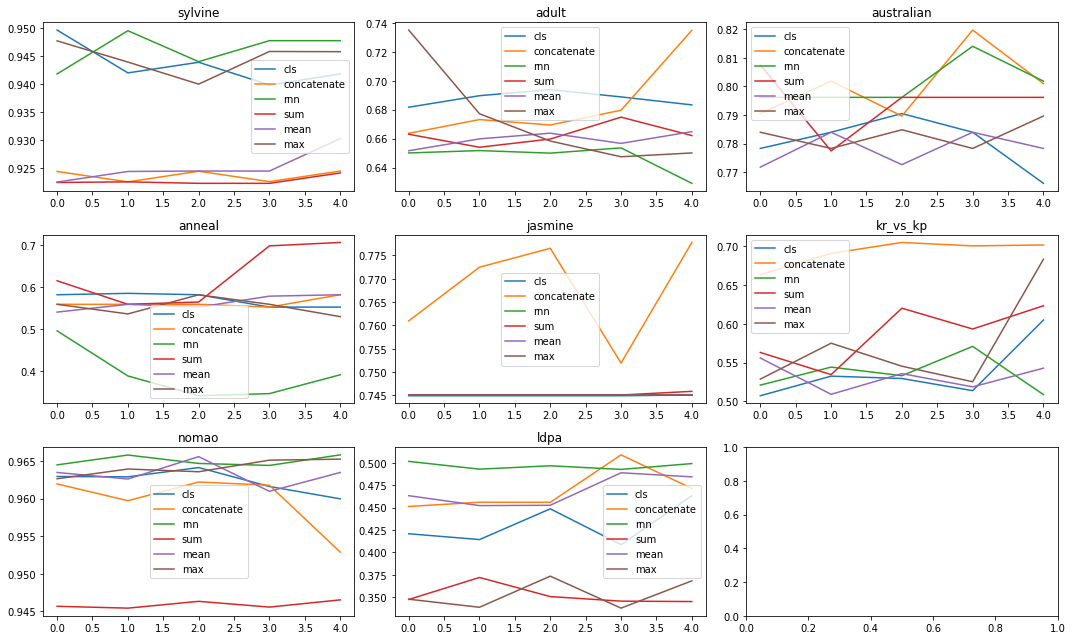

In [52]:
columns = FIG_COLS
rows = math.ceil(len(DATASETS) / FIG_COLS)

fig, axes = plt.subplots(rows, columns, figsize=(15,9))

for ds_idx, plot_ds in enumerate(DATASETS):
    row = math.floor(ds_idx / FIG_COLS)
    col = ds_idx % columns
    ax = axes[row, col]
    for k_agg_idx, k_agg in enumerate(results[plot_ds]):
        
        sorted_by_trial_results = {k: v for k, v in sorted(results[plot_ds][k_agg].items(), key=lambda item: item[1]["trial"])}
        b_accuracies = [sorted_by_trial_results[trial]["balanced_accuracy_max"] for trial in sorted_by_trial_results]

        ax.plot(
            list(results[plot_ds][k_agg].keys()),            
            b_accuracies,
            label=k_agg
        )

#Use adjustable='box-forced' to make the plot area square-shaped as well.
#ax.set_aspect('equal', adjustable='datalim')
    ax.set_title(plot_ds)
    ax.plot()  #Causes an autoscale update.
    ax.legend()
    
fig.tight_layout()
plt.show()

## Parameters vs Accuracy

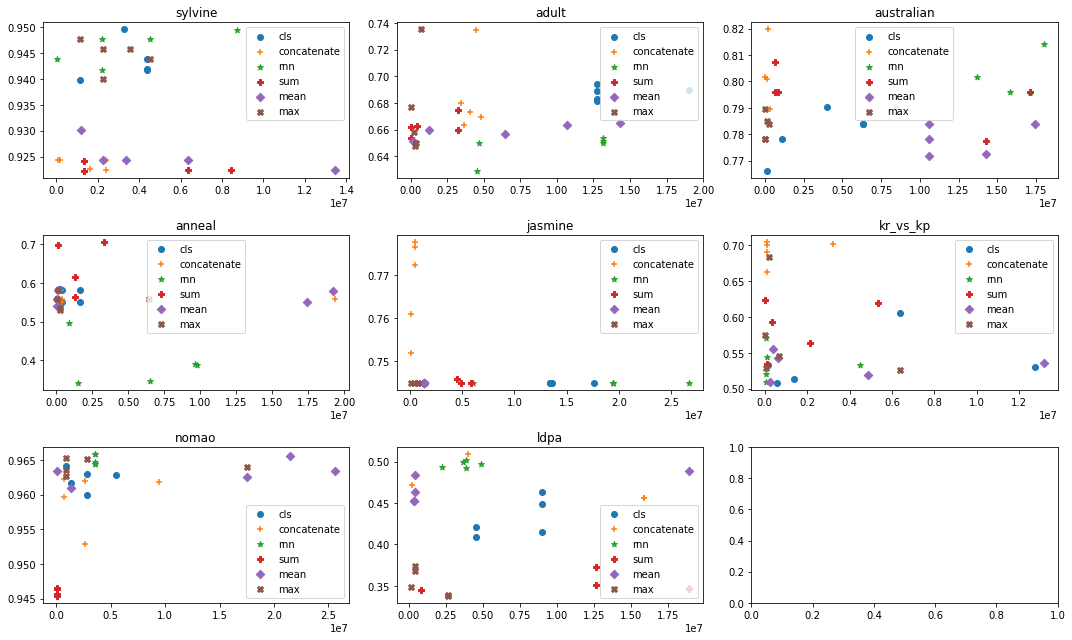

In [53]:
columns = FIG_COLS
rows = math.ceil(len(DATASETS) / FIG_COLS)

fig, axes = plt.subplots(rows, columns, figsize=(15,9))

for ds_idx, plot_ds in enumerate(DATASETS):
    row = math.floor(ds_idx / FIG_COLS)
    col = ds_idx % columns
    ax = axes[row, col]

    for k_agg_idx, k_agg in enumerate(results[plot_ds]):

        n_params =  [results[plot_ds][k_agg][trial]["trainable_params"] for trial in results[plot_ds][k_agg]]
        b_accuracies = [results[plot_ds][k_agg][trial]["balanced_accuracy_max"] for trial in results[plot_ds][k_agg]]

        ax.scatter(
            n_params,
            b_accuracies,
            marker=["o", "+", "*", "P", "D", "X"][k_agg_idx],
            label=k_agg,
        )

    #Use adjustable='box-forced' to make the plot area square-shaped as well.
    #ax.set_aspect('equal', adjustable='datalim')
    ax.set_title(plot_ds)
    ax.legend()
    ax.plot()   #Causes an autoscale update.
    
fig.tight_layout()
plt.show()

## Aggregator vs Accuracy vs Num of params

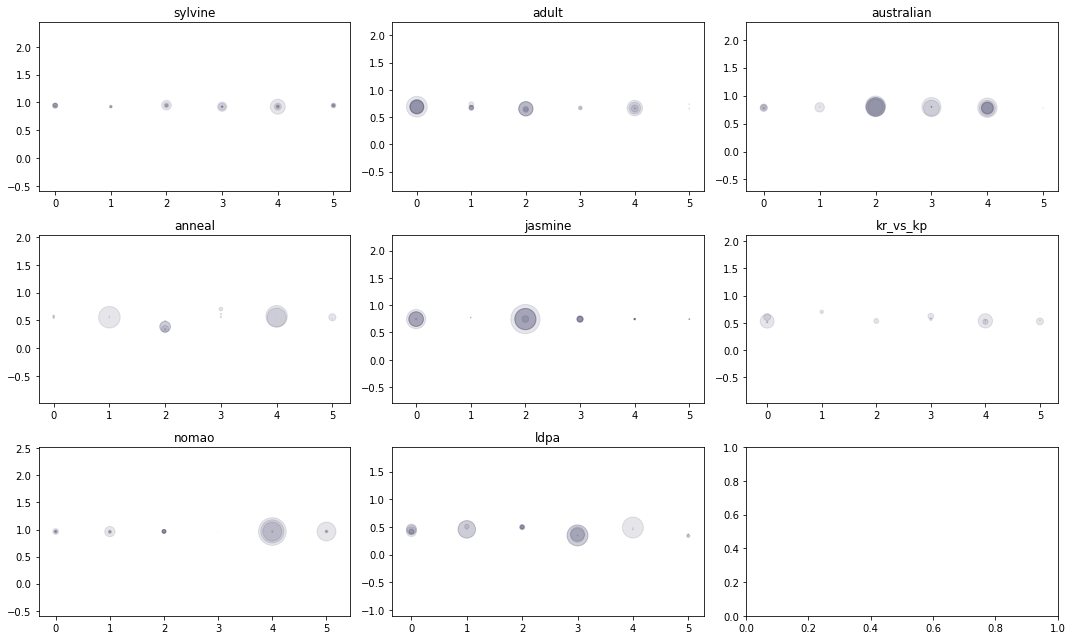

In [54]:
columns = FIG_COLS
rows = math.ceil(len(DATASETS) / FIG_COLS)

fig, axes = plt.subplots(rows, columns, figsize=(15,9))

for ds_idx, plot_ds in enumerate(DATASETS):
    row = math.floor(ds_idx / FIG_COLS)
    col = ds_idx % columns
    ax = axes[row, col]

    for k_agg_idx, k_agg in enumerate(results[plot_ds]):
        for trial in results[plot_ds][k_agg]:

            ax.add_patch(
                plt.Circle(
                    (k_agg_idx, results[plot_ds][k_agg][trial]["balanced_accuracy_max"]),
                    results[plot_ds][k_agg][trial]["trainable_params"] / 100000000, 
                    color='#000033', 
                    alpha=0.1
                )
            )

    #Use adjustable='box-forced' to make the plot area square-shaped as well.
    ax.set_aspect('equal', adjustable='datalim')
    #ax.set_ylim([0, 1])
    ax.set_title(plot_ds)
    ax.plot()   #Causes an autoscale update.
    
fig.tight_layout()
plt.show()

## Aggregator vs accuracy

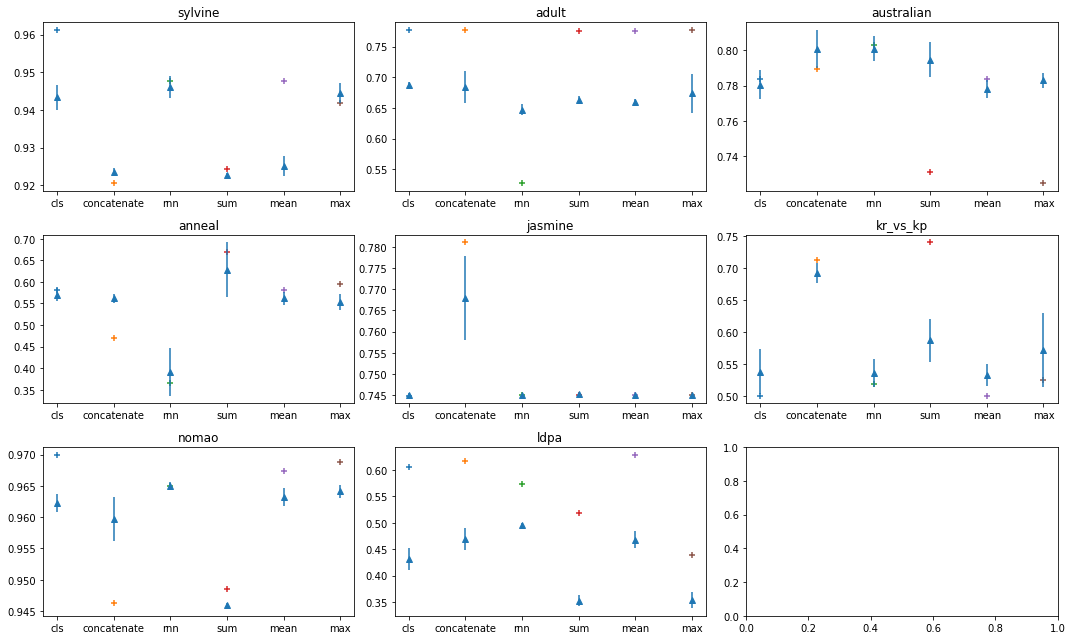

In [55]:
columns = FIG_COLS
rows = math.ceil(len(DATASETS) / FIG_COLS)

fig, axes = plt.subplots(rows, columns, figsize=(15,9))

for ds_idx, plot_ds in enumerate(DATASETS):
    row = math.floor(ds_idx / FIG_COLS)
    col = ds_idx % columns
    ax = axes[row, col]
    
    means = []
    stds = []
    
    for k_agg_idx, k_agg in enumerate(results[plot_ds]):
        
        ax.scatter(
            k_agg, 
            eval_results[plot_ds][k_agg]["balanced_accuracy_val"],
            label=k_agg + "_max",
            marker="+"
        )

        #for trial in results[plot_ds][k_agg]:
        
        b_accs = [results[plot_ds][k_agg][trial]["balanced_accuracy_max"] for trial in results[plot_ds][k_agg]]
        mean = np.mean(b_accs)
        std = np.std(b_accs)
        
        means.append(mean)
        stds.append(std)
        
        
    ax.errorbar(
        list(results[plot_ds].keys()), # Get aggregators
        means, 
        stds, 
        linestyle="None", 
        marker="^"
    )
            
            
    ax.set_title(plot_ds)
    #Use adjustable='box-forced' to make the plot area square-shaped as well.
    #ax.set_aspect('equal', adjustable='datalim')
    #ax.legend()
    ax.plot()   #Causes an autoscale update.
    
fig.tight_layout()
plt.show()

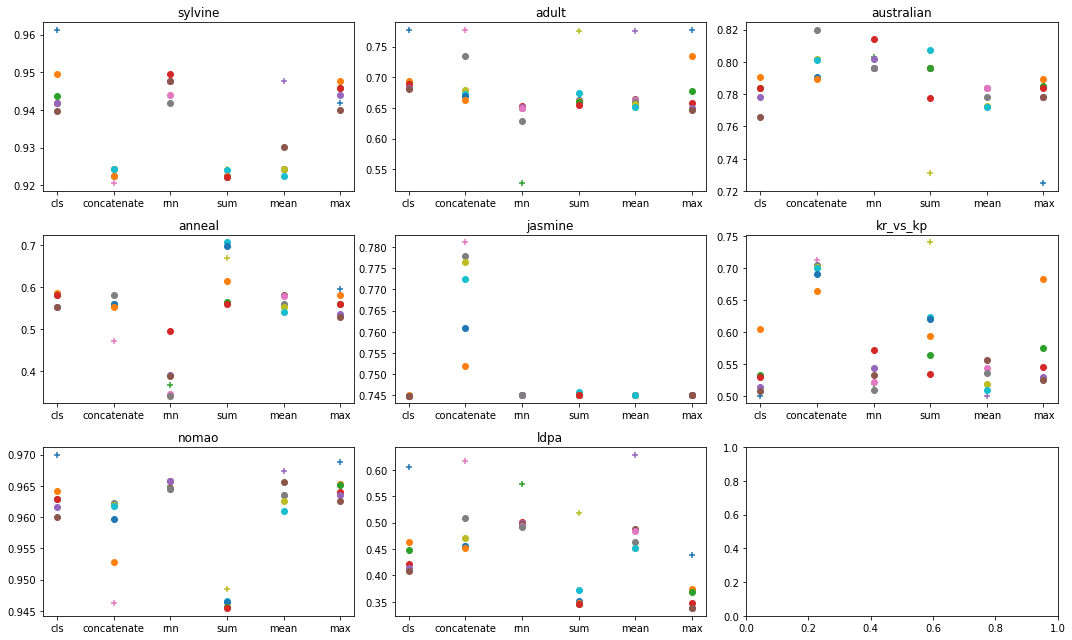

In [56]:
columns = FIG_COLS
rows = math.ceil(len(DATASETS) / FIG_COLS)

fig, axes = plt.subplots(rows, columns, figsize=(15,9))

for ds_idx, plot_ds in enumerate(DATASETS):
    row = math.floor(ds_idx / FIG_COLS)
    col = ds_idx % columns
    ax = axes[row, col]
    for k_agg_idx, k_agg in enumerate(results[plot_ds]):
        
        ax.scatter(
            k_agg, 
            eval_results[plot_ds][k_agg]["balanced_accuracy_val"],
            label=k_agg + "_max",
            marker="+"
        )

        for trial in results[plot_ds][k_agg]:

            ax.scatter(
                k_agg, 
                results[plot_ds][k_agg][trial]["balanced_accuracy_max"],
                label=k_agg
            )
            
            
            
    ax.set_title(plot_ds)
    #Use adjustable='box-forced' to make the plot area square-shaped as well.
    #ax.set_aspect('equal', adjustable='datalim')
    #ax.legend()
    ax.plot()   #Causes an autoscale update.
    
fig.tight_layout()
plt.show()

## Aggregator vs train, val, test accuracy

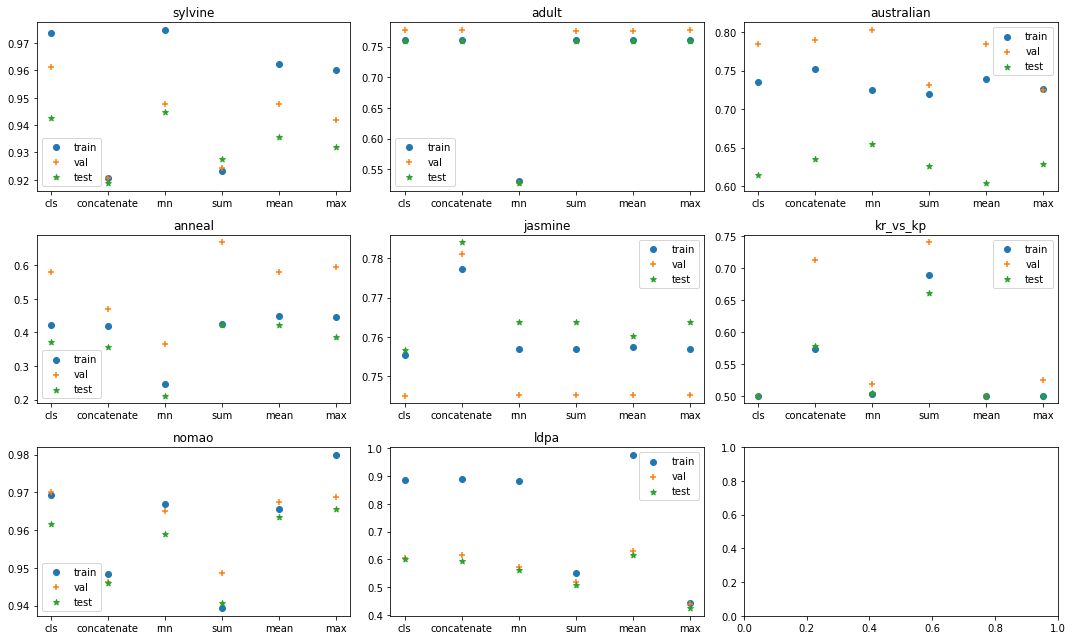

In [57]:
columns = FIG_COLS
rows = math.ceil(len(DATASETS) / FIG_COLS)

fig, axes = plt.subplots(rows, columns, figsize=(15,9))

for ds_idx, plot_ds in enumerate(DATASETS):
    row = math.floor(ds_idx / FIG_COLS)
    col = ds_idx % columns
    ax = axes[row, col]
    
    for partition_idx, partition in enumerate(["train", "val", "test"]):        
        x = []
        y = []
    
        for k_agg_idx, k_agg in enumerate(results[plot_ds]):
            x.append(k_agg)
            y.append(eval_results[plot_ds][k_agg]["balanced_accuracy_" + partition])
        
        ax.scatter(
            x, 
            y,
            marker=["o", "+", "*"][partition_idx],
            label=partition
        )
            
    ax.set_title(plot_ds)
    #Use adjustable='box-forced' to make the plot area square-shaped as well.
    #ax.set_aspect('equal', adjustable='datalim')
    ax.legend()
    ax.plot()   #Causes an autoscale update.

fig.tight_layout()
plt.show()

## Config vs accuracy

In [58]:
all_configs = []

for k_ds in DATASETS:
    this_config  = {"dataset": k_ds}
    
    for k_agg in results[k_ds]:
        this_config["aggregator"] = k_agg
        
        for k_trial in results[k_ds][k_agg]:
            all_configs.append({**this_config, **results[k_ds][k_agg][k_trial]["config"]})  
    

In [59]:
config_df = pd.DataFrame(all_configs)
config_df = pd.merge(config_df, ds_info_df, left_on="dataset", right_on="name", how="left")

'''
config_df = pd.concat(
        [config_df, 
         pd.get_dummies(config_df["dataset"].astype("category"), prefix="dataset")
        ]
    ,axis=1)#.drop(["dataset"], axis=1)


config_df = pd.concat(
        [config_df, 
         pd.get_dummies(config_df["aggregator"].astype("category"), prefix="aggregator")
        ]
    ,axis=1)#.drop(["aggregator"], axis=1)
'''

config_df["dataset_code"] = config_df["dataset"].astype("category").cat.codes
config_df["aggregator_code"] = config_df["aggregator"].astype("category").cat.codes
config_df["numerical_passthrough"] = config_df["numerical_passthrough"].astype("category").cat.codes

In [60]:
config_df

,dataset,aggregator,n_layers,optimizer__lr,n_head,n_hid,dropout,numerical_passthrough,name,features_instances,percent_numerical,percent_missing_values,label,dataset_code,aggregator_code
0,sylvine,cls,3,0.096973,32,32,0.377600,0,sylvine,0.004098,1.000000,0.0,0,7,0
1,sylvine,cls,4,0.087566,32,32,0.400193,0,sylvine,0.004098,1.000000,0.0,0,7,0
2,sylvine,cls,4,0.090218,32,32,0.379982,0,sylvine,0.004098,1.000000,0.0,0,7,0
3,sylvine,cls,4,0.091187,32,32,0.404046,0,sylvine,0.004098,1.000000,0.0,0,7,0
4,sylvine,cls,4,0.059429,1,32,0.354707,0,sylvine,0.004098,1.000000,0.0,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,ldpa,max,1,0.021530,4,256,0.230153,0,ldpa,0.000049,0.714286,0.0,4,5,2
236,ldpa,max,1,0.021208,4,256,0.251674,0,ldpa,0.000049,0.714286,0.0,4,5,2
237,ldpa,max,1,0.023133,4,256,0.226504,0,ldpa,0.000049,0.714286,0.0,4,5,2
238,ldpa,max,2,0.002830,4,256,0.257443,0,ldpa,0.000049,0.714286,0.0,4,5,2


In [61]:
dropable_columns = [    
    "dataset",
    "aggregator",
    #"dataset_code",
    #"aggregator_code",
    "name",
    #"features_instances", 
    #"percent_numerical", 
    #"percent_missing_values",
    #"label"
]

config_vectors = config_df.drop(dropable_columns, axis=1).values
min_max_scaler = preprocessing.MinMaxScaler()
config_vectors = min_max_scaler.fit_transform(config_vectors)

# Correlation matrix

<AxesSubplot:>

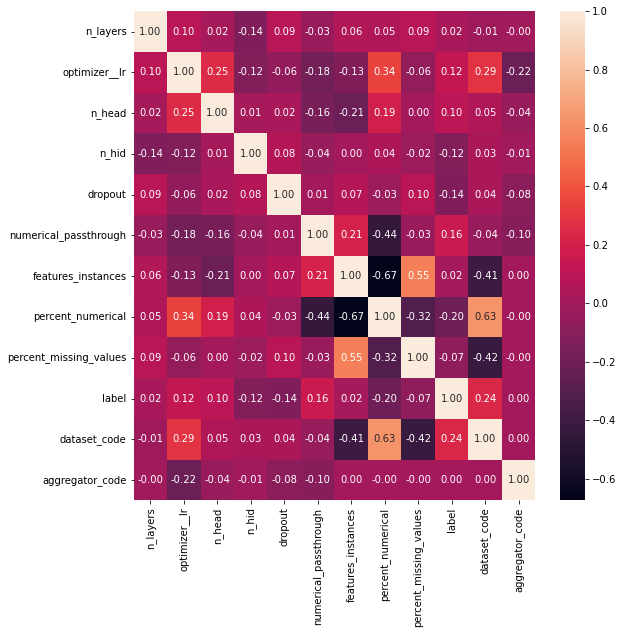

In [62]:
fig = plt.figure(figsize=(9,9))
sns.heatmap(config_df.drop(dropable_columns, axis=1).corr(), annot = True, fmt = '.2f')

In [63]:
pca = manifold.TSNE(n_components=2, random_state=11)
#pca = decomposition.PCA(n_components=2, random_state=11)
plot_vectors = pca.fit_transform(config_vectors)

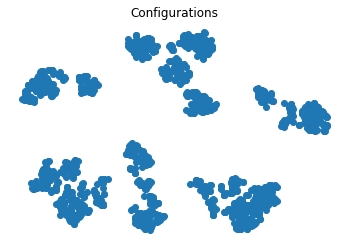

In [30]:
plt.axis("off")
plt.title("Configurations")
_ = plt.scatter(plot_vectors[:, 0], plot_vectors[:, 1])

# Multiple colorings

In [31]:
colors = ["red", "black", "purple", "blue", "orange", "cyan", "green", "gray", "pink"]
markers = ['o', 's', 'D', '^', 'v', '*', '.', ',' ]

In [32]:
list(config_df.keys())

['dataset',
 'aggregator',
 'n_layers',
 'optimizer__lr',
 'n_head',
 'n_hid',
 'dropout',
 'numerical_passthrough',
 'name',
 'features_instances',
 'percent_numerical',
 'percent_missing_values',
 'label',
 'dataset_code',
 'aggregator_code']

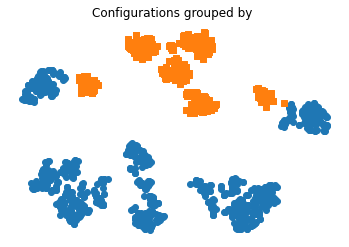

In [33]:
plt.axis("off")
color_attributes = config_df["numerical_passthrough"].values.astype(int)

plt.title("Configurations grouped by ")
for coloring_idx, coloring_attr in enumerate(set(color_attributes)):
    indices = np.argwhere(color_attributes == coloring_attr).flatten()
    _ = plt.scatter(
        plot_vectors[indices, 0], 
        plot_vectors[indices, 1], 
        marker=markers[coloring_idx % len(markers)]
    )

# Clustering

In [34]:
#clustering = cluster.DBSCAN(eps=1.8)
clustering = cluster.KMeans(n_clusters=5)
clustering.fit(config_vectors)

KMeans(n_clusters=5)

In [35]:
colors = ["red", "black", "purple", "blue", "orange", "cyan", "green", "gray", "pink"]
markers = ['o', 's', 'D', '^', 'v', '*', '.', ',' ]
print("Available labels:", set(clustering.labels_))

Available labels: {0, 1, 2, 3, 4}


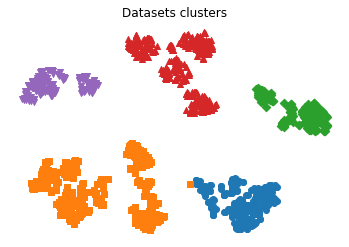

In [36]:
plt.axis('off')

plt.title("Datasets clusters")

for label_idx, label in enumerate(set(clustering.labels_)):
    indices = np.argwhere(clustering.labels_ == label).flatten()
    _ = plt.scatter(
        plot_vectors[indices, 0], 
        plot_vectors[indices, 1], 
        marker=markers[label_idx % len(markers)]
    )
    
    #plt.savefig("assets/datasets_clusters.png", dpi=300)

In [37]:
config_df["cluster_label"] = clustering.labels_
config_df[['dataset', 'aggregator', 'n_layers', 'n_head', 'n_hid',
       'numerical_passthrough', 'name', 'label','cluster_label']].where(
    config_df["cluster_label"] == 1
).dropna()

,dataset,aggregator,n_layers,n_head,n_hid,numerical_passthrough,name,label,cluster_label
180,adult,cls,2.0,16.0,1024.0,0.0,adult,1.0,1.0
181,adult,cls,3.0,32.0,1024.0,0.0,adult,1.0,1.0
182,adult,cls,2.0,32.0,1024.0,0.0,adult,1.0,1.0
183,adult,cls,2.0,32.0,1024.0,0.0,adult,1.0,1.0
184,adult,cls,2.0,32.0,1024.0,0.0,adult,1.0,1.0
...,...,...,...,...,...,...,...,...,...
1071,kr_vs_kp,max,1.0,8.0,512.0,0.0,kr_vs_kp,3.0,1.0
1072,kr_vs_kp,max,1.0,1.0,512.0,0.0,kr_vs_kp,3.0,1.0
1073,kr_vs_kp,max,2.0,32.0,32.0,0.0,kr_vs_kp,3.0,1.0
1076,kr_vs_kp,max,2.0,16.0,32.0,0.0,kr_vs_kp,3.0,1.0


In [38]:
config_df.columns

Index(['dataset', 'aggregator', 'n_layers', 'optimizer__lr', 'n_head', 'n_hid',
       'dropout', 'numerical_passthrough', 'name', 'features_instances',
       'percent_numerical', 'percent_missing_values', 'label', 'dataset_code',
       'aggregator_code', 'cluster_label'],
      dtype='object')